# CNN - Part 2 - AI Training

Colab specifically for training the AI, using the variables data exported from the previous colab.

## Configuring environment

### Installing required libraries



*   Kaggle - Assist with API calls to download dataset
*   Dask[dataframe] - Dataframe for big data
*   Scikeras[Tensorflow] - CNN



In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install dask[dataframe]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install dask-ml[complete] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148 kB 3.9 MB/s 


In [ ]:
!pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing required libraries



*   os - Manipulating paths, accessing the API directory and accessing the dataset files
*   Random - Used for randomizing and assisting with sampling
*   Dask - Library that functions like Pandas, used to facilitate and load the dataset in its entirety
*   Tensorflow - Library used for Machine Learning, Deep learning.
*   Scikeras - Library used for machien learning, assist with Tensorflow and Dask
*   Sklearn - Facilitate splitting dataset into training and test parts
*   Matplotlib - Assist with graphical visualization
*   Seaborn - Assist with graphical visualization. Requires matplotlib



In [ ]:
import os
import joblib
import random
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask_ml as ddml
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import Conv1D, MaxPooling1D, Dense
from keras.layers import Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
import h5py
from tensorflow.python.framework import ops
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

### Connecting to Google Drive

The connection to GD is only made for the following purposes.:
- Loading kaggle api
- Storing finished AI

If you are running locally or wish to load the data in other ways, please edit the required fields.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setting global flags

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/colab_api/"

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/TCC/TCC/"

### Downloading and unzipping dataset

The following is done using the space given by google colab. If you wish to load the data in other ways, please edit the required fields.

In [ ]:
!kaggle datasets download -d devendra416/ddos-datasets

100% 2.68G/2.68G [01:55<00:00, 31.1MB/s]
100% 2.68G/2.68G [01:55<00:00, 24.9MB/s]


In [ ]:
!unzip -n ddos-datasets.zip 

Archive:  ddos-datasets.zip
  inflating: ddos_balanced/final_dataset.csv  
  inflating: ddos_imbalanced/unbalaced_20_80_dataset.csv  


### Loading dataset using Dask

We have obtained two datasets, "final_dataset" and "unbalaced_20_80_dataset". While we will study to decide which is best to use, for the purpose of this AI we will train with both, each with their own instances

A function was also made to assist and make the standard way to import and load the files

In [ ]:
def load_set(filename):
  dataframe = dd.read_csv(filename, blocksize="16MB")
  return dataframe

In [ ]:
ddos_dataset_unbalanced = load_set("/content/ddos_imbalanced/unbalaced_20_80_dataset.csv")
ddos_dataset_balanced = load_set("/content/ddos_balanced/final_dataset.csv")

## Studying dataset

### Null / Empty values

We must confirm if there are any empty or null values

In [ ]:
ddos_dataset_unbalanced.isnull().sum().compute()

Unnamed: 0    0
Flow ID       0
Src IP        0
Src Port      0
Dst IP        0
             ..
Idle Mean     0
Idle Std      0
Idle Max      0
Idle Min      0
Label         0
Length: 85, dtype: int64

In [ ]:
ddos_dataset_balanced.isnull().sum().compute()

Unnamed: 0    0
Flow ID       0
Src IP        0
Src Port      0
Dst IP        0
             ..
Idle Mean     0
Idle Std      0
Idle Max      0
Idle Min      0
Label         0
Length: 85, dtype: int64

We can see that there's no empty/null values. Therefore, we don't need to trouble ourselves with treating the data.

### Variables

Here, we will detail some variables that can be found within the dataset; Mostly to assist with loading the dataset.
Using a dataset as example for information and visualization

#### First array - to_ignore_one

For our first cleaning, we discussed with a security professional and determined some initial items to remove

In [ ]:
to_ignore_one = ["Flow ID",
            "Protocol",
            "Flow Duration",
            "Flow Byts/s",
            "Flow Pkts/s",
            'Bwd Blk Rate Avg', 
            'Bwd Byts/b Avg', 
            'Bwd PSH Flags',
            'Bwd Pkts/b Avg', 
            'Bwd URG Flags', 
            'FIN Flag Cnt',
            'Fwd Blk Rate Avg', 
            'Fwd Byts/b Avg', 
            'Fwd PSH Flags',
            'Fwd Pkts/b Avg', 
            'Fwd URG Flags', 
            'URG Flag Cnt',
            "Tot Bwd Pkts",
            "TotLen Fwd Pkts",
            "TotLen Bwd Pkts",
            "Bwd Pkt Len Max",
            "Bwd Pkt Len Mean",
            "Bwd Pkt Len Std",
            "Bwd IAT Tot",
            "Bwd IAT Mean",
            "Bwd IAT Std",
            "Bwd IAT Max",
            "Bwd IAT Min",
            "Bwd Header Len",
            "Bwd Pkts/s",
            "Bwd Seg Size Avg",
            "Subflow Bwd Pkts",
            "Subflow Bwd Byts",
            "Init Bwd Win Byts",]

#### Second array - to_ignore_two

Using what we have learned from the variable study, we will add the other values to the array of values to remove

In [ ]:
to_ignore_two = [
  "Unnamed: 0",
  "Src IP", 
  #"Src Port",
  "Dst IP", 
  #"Dst Port",
  "Timestamp",
  "Bwd Pkt Len Min",
  "Fwd Header Len",
  "Pkt Len Min",
  "Pkt Len Max",
  "Pkt Len Mean",
  "Pkt Len Std",
  "Pkt Len Var",
  "Down/Up Ratio",
  "Pkt Size Avg",
  "Fwd Seg Size Avg",
  "Subflow Fwd Pkts",
  "Subflow Fwd Byts",
  "Init Fwd Win Byts",
  "Fwd Act Data Pkts",
  "Fwd Seg Size Min",
  "Active Mean",
  "Active Std",
  "Active Max",
  "Active Min",
  "Idle Mean",
  "Idle Std",
  "Idle Max",
  "Idle Min",
]

#### Combining arrays

In [ ]:
to_ignore_three = to_ignore_one + to_ignore_two

- In the loading libraries section, we define Dask as dd.
- The dataset has two csv files, the "unbalanced" and "final". "Unbalanced" has a ratio of 20 ddos - 80 benign packages, while in "final" the ratio is 50-50. For our purposes, we will test both datasets
- The variable naming scheme for each dataset will be based on whether it is "unbalanced" or "balanced" (final)
- We will load a sample of the dataset to assist with training.

In [ ]:
ddos_dataset_unbalanced = ddos_dataset_unbalanced.drop(columns=to_ignore_three)
ddos_dataset_balanced = ddos_dataset_balanced.drop(columns=to_ignore_three)

To make sure our dataset fits our standard, we must study its properties and values.

### Verifying labels

It may be possible that the dataset labels are broken. Let us analyse

In [ ]:
ddos_dataset_unbalanced.dtypes

Src Port              int64
Dst Port              int64
Tot Fwd Pkts          int64
Fwd Pkt Len Max     float64
Fwd Pkt Len Min     float64
Fwd Pkt Len Mean    float64
Fwd Pkt Len Std     float64
Flow IAT Mean       float64
Flow IAT Std        float64
Flow IAT Max        float64
Flow IAT Min        float64
Fwd IAT Tot         float64
Fwd IAT Mean        float64
Fwd IAT Std         float64
Fwd IAT Max         float64
Fwd IAT Min         float64
Fwd Pkts/s          float64
SYN Flag Cnt          int64
RST Flag Cnt          int64
PSH Flag Cnt          int64
ACK Flag Cnt          int64
CWE Flag Count        int64
ECE Flag Cnt          int64
Label                object
dtype: object

In [ ]:
current_labels = {
    "Src Port" : "SrcPort",
    "Dst Port" : "DstPort",
    "Tot Fwd Pkts" : "TotFwdPkts",
    "Fwd Pkt Len Max" : "FwdPktLenMax",
    "Fwd Pkt Len Min" : "FwdPktLenMin",
    "Fwd Pkt Len Mean" : "FwdPktLenMean",
    "Fwd Pkt Len Std" : "FwdPktLenStd",
    "Flow IAT Mean" : "FlowIATMean",
    "Flow IAT Std" : "FlowIATStd",
    "Flow IAT Max " : "FlowIATMax",
    "Flow IAT Min" : "FlowIATMin",
    "Fwd IAT Tot" : "FwdIATTot",
    "Fwd IAT Mean" : "FwdIATMean",
    "Fwd IAT Std" : "FwdIATStd",
    "Fwd IAT Max" : "FwdIATMax",
    "Fwd IAT Min" : "FwdIATMin",
    "Fwd Pkts/s" : "FwdPkts",
    "SYN Flag Cnt" : "SYNFlagCnt",
    "RST Flag Cnt" : "RSTFlagCnt",
    "PSH Flag Cnt" : "PSHFlagCnt",
    "ACK Flag Cnt" : "ACKFlagCnt",
    "CWE Flag Count" : "CWEFlagCount",
    "ECE Flag Cnt" : "ECEFlagCnt",
     "Label" : "Label",
}

To avoid complications, we will.:
- Remove spaces and replace them with underlines
- Remove special characters (eg.: "/")

In [ ]:
ddos_dataset_unbalanced = ddos_dataset_unbalanced.rename(columns=current_labels) 
ddos_dataset_balanced = ddos_dataset_balanced.rename(columns=current_labels) 

Confirming

In [ ]:
ddos_dataset_unbalanced.head()

,SrcPort,DstPort,TotFwdPkts,FwdPktLenMax,FwdPktLenMin,FwdPktLenMean,FwdPktLenStd,FlowIATMean,FlowIATStd,Flow IAT Max,...,FwdIATMax,FwdIATMin,FwdPkts,SYNFlagCnt,RSTFlagCnt,PSHFlagCnt,ACKFlagCnt,CWEFlagCount,ECEFlagCnt,Label
0,37882,80,1,0.0,0.0,0.00,0.0,8660.000000,0.000000,8660.0,...,0.0,0.0,115.473441,0,0,0,1,0,0,ddos
1,80,63287,4,935.0,0.0,233.75,467.5,971.500000,2104.124973,5260.0,...,5541.0,46.0,686.224052,1,0,0,0,1,1,ddos
2,63095,80,1,0.0,0.0,0.00,0.0,3396.000000,0.000000,3396.0,...,0.0,0.0,294.464075,0,0,0,1,0,0,ddos
3,52341,80,1,0.0,0.0,0.00,0.0,2390.000000,0.000000,2390.0,...,0.0,0.0,418.410042,0,0,0,1,0,0,ddos
4,80,57459,4,935.0,0.0,233.75,467.5,2893.666667,6770.577661,16711.0,...,17077.0,38.0,230.388204,1,0,0,0,1,1,ddos


In [ ]:
ddos_dataset_balanced.head()

,SrcPort,DstPort,TotFwdPkts,FwdPktLenMax,FwdPktLenMin,FwdPktLenMean,FwdPktLenStd,FlowIATMean,FlowIATStd,Flow IAT Max,...,FwdIATMax,FwdIATMin,FwdPkts,SYNFlagCnt,RSTFlagCnt,PSHFlagCnt,ACKFlagCnt,CWEFlagCount,ECEFlagCnt,Label
0,4504,80,29,86.0,0.0,2.965517,15.969799,55206.416667,195478.316654,1566821.0,...,1805015.0,167.0,7.295851,1,0,0,0,0,0,ddos
1,4504,80,1,0.0,0.0,0.000000,0.000000,63.000000,0.000000,63.0,...,0.0,0.0,15873.015873,0,0,0,1,0,0,ddos
2,4505,80,2,86.0,0.0,43.000000,60.811183,68011.142857,110862.707451,232203.0,...,134.0,134.0,4.200992,1,0,0,0,0,0,ddos
3,4505,80,2,0.0,0.0,0.000000,0.000000,75.500000,98.287843,145.0,...,145.0,145.0,13245.033113,0,0,0,1,0,0,ddos
4,4506,80,2,73.0,0.0,36.500000,51.618795,78751.166667,118675.492251,232355.0,...,179.0,179.0,4.232742,1,0,0,0,0,0,ddos


## AI Configuring Segment

### Treating data

In [ ]:
X_unbalanced = ddos_dataset_unbalanced
y_unbalanced = ddos_dataset_unbalanced.pop('Label').map({'Benign': 0, 'ddos': 1})

In [ ]:
X_balanced = ddos_dataset_balanced
y_balanced = ddos_dataset_balanced.pop('Label').map({'Benign': 0, 'ddos': 1})

Splitting into test, validation, training arrays

### Generating data training sets

First split - 80/20

Second split - 80/10/10

Consider removing val data, only train & test. 80/20?

-Balanced

In [ ]:
X_balanced_Train, X_balanced_Test, y_balanced_Train, y_balanced_Test = ddml.model_selection.train_test_split(X_balanced, y_balanced, test_size=0.4, random_state=1)
X_balanced_Val, X_balanced_Test, y_balanced_Val, y_balanced_Test = ddml.model_selection.train_test_split(X_balanced_Test, y_balanced_Test, test_size=0.5, random_state=1)

/usr/local/lib/python3.7/dist-packages/dask_ml/model_selection/_split.py:469: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  category=FutureWarning,


-Unbalanced

In [ ]:
X_unbalanced_Train, X_unbalanced_Test, y_unbalanced_Train, y_unbalanced_Test = ddml.model_selection.train_test_split(X_unbalanced, y_unbalanced, test_size=0.4, random_state=1)
X_unbalanced_Val, X_unbalanced_Test, y_unbalanced_Val, y_unbalanced_Test = ddml.model_selection.train_test_split(X_unbalanced_Test, y_unbalanced_Test, test_size=0.5, random_state=1)

### Computing variables

Due to the size and quirks of dask + keras, we need to compute all data for it to not be "lazy"

In [ ]:
X_balanced_Train = X_balanced_Train.compute()
X_balanced_Test = X_balanced_Test.compute()
X_balanced_Val = X_balanced_Val.compute()
y_balanced_Train = y_balanced_Train.compute()
y_balanced_Test = y_balanced_Test.compute()
y_balanced_Val = y_balanced_Val.compute()

In [ ]:
X_unbalanced_Train = X_unbalanced_Train.compute()
X_unbalanced_Test = X_unbalanced_Test.compute()
X_unbalanced_Val = X_unbalanced_Val.compute()
y_unbalanced_Train = y_unbalanced_Train.compute()
y_unbalanced_Test = y_unbalanced_Test.compute()
y_unbalanced_Val = y_unbalanced_Val.compute()

## Configuring CNN

### Defining model

We'll use 4 functions, three of which are to determine the block for the models and one to build from there.

convo_block_first - First convolutional block, using params pre defined. 
convo_block - Blocks that stands in between convo_block_first and final_block.
final_block - The last block, with the final neuron. Notice that we're outputting with sigmoid activation, to give us a percentage. We could have used softmax (mode.add(Dense(2, activation='softmax'))) to return two percentages instead. To confirm.

Notice how every function, exception of final_block, uses a params array. Proceed to the next segment to learn more.

This model was defined by the following resource.: [Convolutional neural networks for well log analysis tutorial](https://www.youtube.com/watch?v=zOv3TnjKYmg) and the [respective colab file](https://colab.research.google.com/drive/1F-2cOcw7hM-A7gfUuhAlXgEYi-elI8Lw?usp=sharing#scrollTo=EzdsyZ0FeDr1)

In [ ]:
def convo_block_first(model, params):
    model.add(Conv1D(filters = params['Conv1D_1_output_filters'], 
                     kernel_size = params['Conv1D_1_kernel_size'], 
                     padding = params['Conv1D_1_padding'], 
                     input_shape = params["input_shape"]))
    if params['Conv1D_1_batchnorm']:
        model.add(BatchNormalization())
    model.add(Activation(params['Conv1D_1_activation']))
    if params['Conv1D_1_maxpool']:
        model.add(MaxPooling1D(pool_size=params['Conv1D_1_maxpool_size'], 
                               padding = params['Conv1D_1_maxpool_padding'], 
                               data_format='channels_last'))
    if params['Conv1D_1_dropout']:
        model.add(Dropout(params['Conv1D_1_dropout_rate']))
    return model

def convo_block(model, params):
    model.add(Conv1D(filters = params['Conv1D_mid_output_filters'], 
                     kernel_size = params['Conv1D_mid_kernel_size'], 
                     padding = params['Conv1D_mid_padding']))
    if params['Conv1D_mid_batchnorm']:
        model.add(BatchNormalization())
    model.add(Activation(params['Conv1D_mid_activation']))
    if params['Conv1D_mid_maxpool']:      
        model.add(MaxPooling1D(pool_size=params['Conv1D_mid_maxpool_size'],
                               padding = params['Conv1D_mid_maxpool_padding'],
                               data_format='channels_last'))
    if params['Conv1D_mid_dropout']: 
        model.add(Dropout(params['Conv1D_mid_dropout_rate']))
    return model

def final_block(model):
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid')) # Probability of being ddos
    return model
# Consider softmax, dense(2)
def build_model(params):
    model = Sequential()
    model = convo_block_first(model, params)
    for block in range(1,params['num_conv_blocks']):
        model = convo_block(model, params)
    model = final_block(model)
    return model

### Hyperparameters

These parameters are used to set and define the neurons for our CNN.

- 'Conv1D_1_batchnorm': Bool. Normalizes if true.
- 'Conv1D_1_activation': Str. Activation for first block
- 'Conv1D_1_maxpool': Bool. Maxpool for first block?
- 'Conv1D_1_maxpool_padding': Str. What padding for maxpool if present?
- 'Conv1D_1_dropout': Bool. Set dropout?
- 'Conv1D_mid_padding': Str. What padding for middle block?
- 'Conv1D_mid_batchnorm': Bool. Normalizes if true.
- 'Conv1D_mid_maxpool_padding': Str. What padding for maxpool?
- 'Conv1D_mid_dropout': Bool. Set dropout?
- 'Conv1D_mid_maxpool': Bool. Maxpool for middle block?
- 'Conv1D_1_dropout_rate': Float. What should the dropout rate be for first block?
- 'Conv1D_mid_dropout_rate': Float. What should the dropout rate be for middle blocks?
- 'decay': Float. What should the decay rate be?
- 'Conv1D_1_output_filters': Int. Filters for output
- 'batch_size': Int. Size of batch.
- 'Conv1D_mid_kernel_size': Int. Kernelling
- 'Conv1D_1_padding': Str. ['valid', 'same']? 
- 'Conv1D_mid_activation': Str. ['relu', 'sigmoid', 'tanh']
- 'learning_rate': Int. For learning rate.
- 'num_conv_blocks': Int. How many blocks in between to add?
- 'Conv1D_1_kernel_size': Int. How big should the kernel be?
- 'Conv1D_mid_output_filters': Int. Number of filters in mid blocks
- 'Conv1D_1_maxpool_size': Int. Size of maxpool.
- 'Conv1D_mid_maxpool_size': Int. Size of maxpool.
- 'Conv1D_mid_kernel_size': Int. Kernel size.

In [ ]:
params= {'Conv1D_1_batchnorm': 'True', 
         'Conv1D_1_activation':'relu', #sigmoid
         'Conv1D_1_maxpool': 'True',
         'Conv1D_1_maxpool_padding': 'same', 
         'Conv1D_1_dropout': 'False', 
         'Conv1D_mid_padding':'same',
         'Conv1D_mid_batchnorm':'True', 
         'Conv1D_mid_maxpool_padding': 'same',
         'Conv1D_mid_dropout': 'True', 
         'Conv1D_mid_maxpool':'True',
         'Conv1D_1_dropout_rate': 0.01, 
         'Conv1D_mid_dropout_rate': 0.01, 
         'decay': 0.0001, 
         #'Conv1D_1_output_filters': 19,
         'Conv1D_1_output_filters': 19,
         'batch_size': 10000,
         'batch_size': 10000,
         'Conv1D_mid_kernel_size': 4} #3

params['Conv1D_1_padding'] = 'valid'; 
params['Conv1D_mid_activation'] = 'relu'
params['learning_rate'] = 0.01 #0.001
params['num_conv_blocks'] = 3
params['Conv1D_1_kernel_size'] = 7
#params['Conv1D_mid_output_filters'] = 16
params['Conv1D_mid_output_filters'] = 14
params['Conv1D_1_maxpool_size'] = 3
params['Conv1D_mid_maxpool_size'] = 3
params['Conv1D_mid_kernel_size'] = 3

### Previous

#### 2022-10-27 

Failed - Memory limit reached
```
params= {'Conv1D_1_batchnorm': 'True', 
         'Conv1D_1_activation':'sigmoid', 
         'Conv1D_1_maxpool': 'True',
         'Conv1D_1_maxpool_padding': 'same', 
         'Conv1D_1_dropout': 'False', 
         'Conv1D_mid_padding':'same',
         'Conv1D_mid_batchnorm':'True', 
         'Conv1D_mid_maxpool_padding': 'same',
         'Conv1D_mid_dropout': 'True', 
         'Conv1D_mid_maxpool':'True',
         'Conv1D_1_dropout_rate': 0.1, 
         'Conv1D_mid_dropout_rate': 0.1, 
         'decay': 0.0001, 
         'Conv1D_1_output_filters': 19,
         'batch_size': 100,
         'batch_size': 100,
         'Conv1D_mid_kernel_size': 3}

params['Conv1D_1_padding'] = 'valid'; 
params['Conv1D_mid_activation'] = 'relu'
params['learning_rate'] = 0.002
params['num_conv_blocks'] = 3
params['Conv1D_1_kernel_size'] = 7
params['Conv1D_mid_output_filters'] = 16
params['Conv1D_1_maxpool_size'] = 3
params['Conv1D_mid_maxpool_size'] = 3
params['Conv1D_mid_kernel_size'] = 3
```



#### 2022-10-28

Failed - Started at 17:07.


hyperparams.
```
params= {'Conv1D_1_batchnorm': 'True', 
         'Conv1D_1_activation':'sigmoid', 
         'Conv1D_1_maxpool': 'True',
         'Conv1D_1_maxpool_padding': 'same', 
         'Conv1D_1_dropout': 'False', 
         'Conv1D_mid_padding':'same',
         'Conv1D_mid_batchnorm':'True', 
         'Conv1D_mid_maxpool_padding': 'same',
         'Conv1D_mid_dropout': 'True', 
         'Conv1D_mid_maxpool':'True',
         'Conv1D_1_dropout_rate': 0.1, 
         'Conv1D_mid_dropout_rate': 0.1, 
         'decay': 0.0001, 
         'Conv1D_1_output_filters': 19,
         'batch_size': 209,
         'batch_size': 209,
         'Conv1D_mid_kernel_size': 3}

params['Conv1D_1_padding'] = 'valid'; 
params['Conv1D_mid_activation'] = 'relu'
params['learning_rate'] = 0.01
params['num_conv_blocks'] = 3
params['Conv1D_1_kernel_size'] = 7
params['Conv1D_mid_output_filters'] = 16
params['Conv1D_1_maxpool_size'] = 3
params['Conv1D_mid_maxpool_size'] = 3
params['Conv1D_mid_kernel_size'] = 3
```

& Optimizers -- mean_squared_error -> binary_crossentropy



#### 2022-11-01

Running - Started at 10:02.


hyperparams.
```
params= {'Conv1D_1_batchnorm': 'True', 
         'Conv1D_1_activation':'sigmoid', 
         'Conv1D_1_maxpool': 'True',
         'Conv1D_1_maxpool_padding': 'same', 
         'Conv1D_1_dropout': 'False', 
         'Conv1D_mid_padding':'same',
         'Conv1D_mid_batchnorm':'True', 
         'Conv1D_mid_maxpool_padding': 'same',
         'Conv1D_mid_dropout': 'True', 
         'Conv1D_mid_maxpool':'True',
         'Conv1D_1_dropout_rate': 0.1, 
         'Conv1D_mid_dropout_rate': 0.1, 
         'decay': 0.0001, 
         'Conv1D_1_output_filters': 19,
         'batch_size': 100,
         'batch_size': 100,
         'Conv1D_mid_kernel_size': 3}

params['Conv1D_1_padding'] = 'valid'; 
params['Conv1D_mid_activation'] = 'relu'
params['learning_rate'] = 0.01
params['num_conv_blocks'] = 3
params['Conv1D_1_kernel_size'] = 7
params['Conv1D_mid_output_filters'] = 16
params['Conv1D_1_maxpool_size'] = 3
params['Conv1D_mid_maxpool_size'] = 3
params['Conv1D_mid_kernel_size'] = 3
```

& Optimizers -- Adam->SDG

batch_size -- 209->100

epochs -- 25->100



### Creating the CNN model

- Balanced

In [ ]:
#input_shape = X_balanced_Train.shape[1:]
input_shape = (X_balanced_Train.shape[1], 1)
params["input_shape"] = input_shape
model_balanced = build_model(params)
optimizer = keras.optimizers.Adam(lr=params['learning_rate'],
                                  beta_1=0.9, 
                                  beta_2=0.999, 
                                  clipnorm=1, 
                                  decay=params['decay'])
#optimizer = keras.optimizers.SGD(learning_rate=params['learning_rate'])
model_balanced.compile(optimizer = optimizer,
              loss = "binary_crossentropy",
              metrics = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()])
model_balanced.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 19)            152       
                                                                 
 batch_normalization (BatchN  (None, 17, 19)           76        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 17, 19)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 19)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 19)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 14)             8

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


- Unbalanced

In [ ]:
#input_shape = X_unbalanced_Train.shape[1:]
input_shape = (X_unbalanced_Train.shape[1], 1)
params["input_shape"] = input_shape
model_unbalanced = build_model(params)
optimizer = keras.optimizers.Adam(lr=params['learning_rate'],
                                  beta_1=0.9, 
                                  beta_2=0.999, 
                                  clipnorm=1, 
                                  decay=params['decay'])
#optimizer = keras.optimizers.SGD(learning_rate=params['learning_rate'])
model_unbalanced.compile(optimizer = optimizer,
              loss = "binary_crossentropy",
              metrics = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()])
model_unbalanced.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 17, 19)            152       
                                                                 
 batch_normalization_3 (Batc  (None, 17, 19)           76        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 17, 19)            0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 6, 19)            0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 19)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 6, 14)            

## Training

Putting the fit and training model inside a function

In [ ]:
def cnn_train_model(xTrain, yTrain, xVal, yVal, model_to_run, filename, epochs):
  check_out_num_blocks = [0, 1, 2, 3]
  #histories = [0,0,0,0]
  params['num_conv_blocks'] = check_out_num_blocks[0]
  #params['filename'] = 'run_'+str(0) + '_' + str(check_out_num_blocks[0])+'_blocks' + "_" + filename
  params['filename'] = datetime.today().strftime('%Y-%m-%d-%H:%M:%S') + '_' + str(check_out_num_blocks[0])+'_blocks' + "_" + filename
  model_checkpoint = ModelCheckpoint(params['filename']+'.h5', 
                                        monitor='accuracy',
                                      save_best_only = True,
                                      mode='max')
  es = EarlyStopping(monitor='accuracy', patience=100)
  log_dir = 'tb_logs/'+params['filename']+filename
  tb = TensorBoard(log_dir=log_dir)
  file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
  file_writer.set_as_default()
  hparams = {i:params[i] for i in params if i in ['Conv1D_mid_kernel_size', 'num_conv_blocks', 'learning_rate']}
  histories = model_to_run.fit(x=xTrain, y=yTrain,
                          batch_size=params['batch_size'],
                          epochs=epochs, 
                          verbose=1, 
                          callbacks=[model_checkpoint, es, tb, hp.KerasCallback(log_dir, hparams, trial_id=params['filename'])], 
                          validation_data=(xVal, yVal), 
                          shuffle=False,
                          class_weight=None, sample_weight=None, initial_epoch=0)
  model_to_run.save(file_path + "AIV6_" + datetime.today().strftime('%Y-%m-%d-%H:%M:%S') + "_" + str(filename) + ".h5")
  return histories


#### Balanced

In [ ]:
histories_balanced = cnn_train_model(X_balanced_Train, 
                                     y_balanced_Train, 
                                     X_balanced_Val, 
                                     y_balanced_Val, 
                                     model_balanced, "balanced",
                                     1000)

Epoch 1/1000
768/768 [==============================] - 24s 17ms/step - loss: 0.0620 - mean_absolute_error: 0.0204 - accuracy: 0.0032 - val_loss: 4.1116 - val_mean_absolute_error: 0.5058 - val_accuracy: 0.0000e+00
Epoch 2/1000
768/768 [==============================] - 11s 15ms/step - loss: 0.2572 - mean_absolute_error: 0.0888 - accuracy: 0.0049 - val_loss: 2.6105 - val_mean_absolute_error: 0.5054 - val_accuracy: 0.0000e+00
Epoch 3/1000
768/768 [==============================] - 12s 15ms/step - loss: 0.2788 - mean_absolute_error: 0.0997 - accuracy: 0.0047 - val_loss: 2.3469 - val_mean_absolute_error: 0.5079 - val_accuracy: 0.0000e+00
Epoch 4/1000
768/768 [==============================] - 12s 15ms/step - loss: 0.2664 - mean_absolute_error: 0.1007 - accuracy: 0.0017 - val_loss: 2.2648 - val_mean_absolute_error: 0.5112 - val_accuracy: 0.0000e+00
Epoch 5/1000
768/768 [==============================] - 12s 15ms/step - loss: 0.2215 - mean_absolute_error: 0.0902 - accuracy: 0.0010 - val_loss

#### Unbalanced

In [ ]:
histories_unbalanced = cnn_train_model(X_unbalanced_Train, 
                                       y_unbalanced_Train, 
                                       X_unbalanced_Val, 
                                       y_unbalanced_Val, 
                                       model_unbalanced, "unbalanced",
                                       1000)

Epoch 1/1000
458/458 [==============================] - 10s 18ms/step - loss: 0.1214 - mean_absolute_error: 0.0435 - accuracy: 2.1879e-06 - val_loss: 1.3712 - val_mean_absolute_error: 0.1700 - val_accuracy: 0.0000e+00
Epoch 2/1000
458/458 [==============================] - 7s 16ms/step - loss: 0.3247 - mean_absolute_error: 0.1367 - accuracy: 9.1890e-06 - val_loss: 1.0105 - val_mean_absolute_error: 0.1713 - val_accuracy: 0.0000e+00
Epoch 3/1000
458/458 [==============================] - 7s 16ms/step - loss: 0.4305 - mean_absolute_error: 0.2378 - accuracy: 5.0321e-06 - val_loss: 0.7337 - val_mean_absolute_error: 0.1777 - val_accuracy: 0.0000e+00
Epoch 4/1000
458/458 [==============================] - 7s 16ms/step - loss: 0.3690 - mean_absolute_error: 0.1994 - accuracy: 0.0000e+00 - val_loss: 1.0227 - val_mean_absolute_error: 0.1715 - val_accuracy: 0.0000e+00
Epoch 5/1000
458/458 [==============================] - 7s 16ms/step - loss: 0.3620 - mean_absolute_error: 0.2137 - accuracy: 0.000

#### Exporting AI

## Plotting graphics

#### Error decrease

##### Balanced

##### Unbalanced

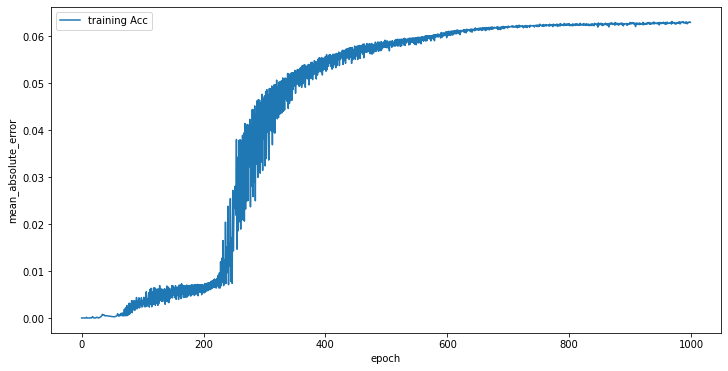

In [ ]:
history = histories_unbalanced

f = plt.figure(figsize=(12,6))

plt.plot(history.history['accuracy'], label ='training Acc')
#plt.plot(history.history['val_mean_absolute_error'], label='validation mean abs err')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend()
f.savefig('val_mean_absolute_error_unbalanced.png',dpi=300,bbox_inches='tight')

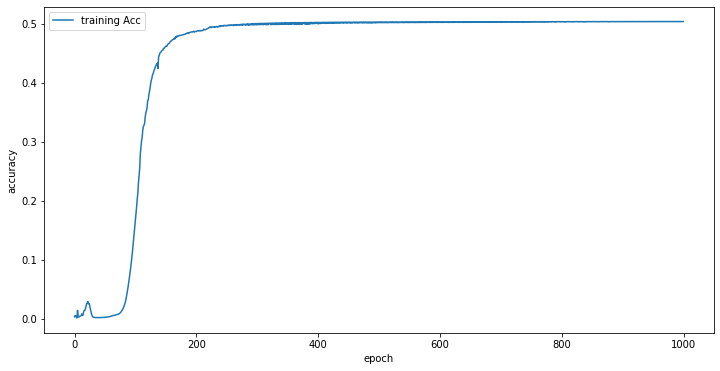

In [ ]:
history = histories_balanced

f = plt.figure(figsize=(12,6))

plt.plot(history.history['accuracy'], label ='training Acc')
#plt.plot(history.history['val_mean_absolute_error'], label='validation mean abs err')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
f.savefig('val_mean_absolute_error_balanced.png',dpi=300,bbox_inches='tight')

#### Tensorboard

In [ ]:
%tensorboard --'logdir' 'tb_logs'

## Closing colab

Once everything's done, the colab will automatically close the session

In [ ]:
from google.colab import runtime
runtime.unassign()

## Resources

[A Beginner’s Guide To Scikit-Learn’s MLPClassifier](https://analyticsindiamag.com/a-beginners-guide-to-scikit-learns-mlpclassifier/) - 2022-11-05

[https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/) - 2022-11-05

[Checkpoint deep-learning-models - keras/](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) -2022-11-14